In [107]:
import pandas as pd
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### Loading the data 

In [125]:
data = pd.read_csv('Data/data.csv')
pd.set_option('display.max_columns', None)
data.shape

(119011, 34)

In [3]:
data.tail()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,PLAYER_AST,PLAYER_WEIGHT,DEFENDER_OREB,DEFENDER_DREB,DEFENDER_STL,DEFENDER_BLK,DEFENDER_WEIGHT
119006,21400175,"NOV 21, 2014 - MIL @ TOR",A,L,-42,3,4,8:55,15.2,0,0.8,22.9,3,missed,BRUNO CABOCLO,203998,10.6,0,0,JARED DUDLEY,201162,197.5,202.5,7.2,46.8,38.5,71.6,1.8,101.25,0.1,0.1,0.0,0.1,98.10
119007,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,3,3,1:35,3.3,1,2.4,6.7,2,made,JULIUS RANDLE,203944,5.3,1,2,KOSTAS PAPANIKOLAOU,203123,200.0,202.5,4.2,35.0,29.2,72.2,2.0,101.25,0.0,0.0,0.0,0.0,112.50
119008,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,2,2,10:10,24.0,0,0.3,4.1,2,made,JULIUS RANDLE,203944,3.2,1,2,DWIGHT HOWARD,2730,207.5,202.5,15.8,59.3,50.0,52.8,1.2,119.25,0.0,0.0,0.0,0.0,112.50
119009,21400744,"FEB 05, 2015 - SAC vs. DAL",H,L,-23,9,4,3:21,13.3,5,5.4,21.9,2,missed,RICKY LEDO,203495,5.0,0,0,NIK STAUSKAS,203917,195.0,201.0,4.4,36.5,32.2,85.9,0.9,92.25,0.9,1.2,0.4,0.1,88.00
119010,21400498,"JAN 03, 2015 - MIN vs. UTA",H,L,-12,7,4,0:26,2.6,1,0.7,4.3,2,made,TOURE' MURRY,203315,2.8,1,2,ANTHONY BENNETT,203461,200.0,192.5,5.2,42.1,30.4,64.1,0.8,110.25,0.2,0.0,0.2,0.0,87.75


In [4]:
data.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'PLAYER_NAME', 'PLAYER_ID', 'PLAYER_HEIGHT',
       'DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
       'PLAYER_FT%', 'PLAYER_AST', 'PLAYER_WEIGHT', 'DEFENDER_OREB',
       'DEFENDER_DREB', 'DEFENDER_STL', 'DEFENDER_BLK', 'DEFENDER_WEIGHT'],
      dtype=object)

### Manipulating the data

In [126]:
# separate data into matrix of predictor variables and vector of target variables
names = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
         'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST',
         'PLAYER_HEIGHT','DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
          'PLAYER_FT%','DEFENDER_STL', 'DEFENDER_BLK', 'SHOT_RESULT']

# converting data to usable numerical data
# todo: move this to preprocessing 
def convert_time(time_string):
    time = time_string.split(':')
    return float(time[0])*60 + float(time[1])

# convert game_clock to seconds
data['GAME_CLOCK'] = data['GAME_CLOCK'].apply(lambda x: convert_time(x))

# convert shot_result to either 0 or 1
data['SHOT_RESULT'] = (data['SHOT_RESULT'] == 'made').astype(int)
# convert win to either 0 

# encode categorical data 
data_encoded = pd.get_dummies(data[names])

# split into train and test set with roughly 75-25 split
train, test = train_test_split(data_encoded, test_size=0.25)
Xtrain = train.drop(['SHOT_RESULT'], axis=1)
ytrain = train['SHOT_RESULT']
Xtest = test.drop(['SHOT_RESULT'], axis=1)
ytest = test['SHOT_RESULT']

### Setting the baseline

First baseline we consider is to predict every shot within 5 feet of the basket as a make and anything else as a miss. 

In [118]:
yhat = (Xtest['SHOT_DIST'] <= 5).astype(int)
acc = np.mean(yhat == ytest)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.606695


A more complex baseline we can try is to use k-nn algorithm. First, we need to normalize the data so that no one parameter exerts more influence on the result than others. 

In [119]:
# without normalizing data 
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [120]:
yhat_ts = neigh.predict(Xtest)
acc = np.mean(ytest.values == yhat_ts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.571606


In [121]:
# with normaliziation 
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_norm = scaler.transform(Xtrain)
scaler.fit(Xtest)
Xtest_norm = scaler.transform(Xtest)

neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain_norm,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [122]:
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.579605


In [124]:
# trying different k's
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(Xtrain_norm,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 10: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=30)
neigh.fit(Xtrain_norm,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 30: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(Xtrain_norm,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 50: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(Xtrain_norm,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 100: {0:f}'.format(acc))

Accuracy for k = 10: 0.570195
Accuracy for k = 30: 0.586899
Accuracy for k = 50: 0.593789
Accuracy for k = 100: 0.599738


Accuracy increases as k increases but the increases get smaller as k gets larger and larger. Let's try manually assigning weights to normalized features now and transforming features 

### Visualizing relationship between features and output

The goal is to see if there are trends between the features and the outcome. This is so we can manually input some weights for the KNN method to increase the baseline accuracy

In [16]:
y = ytrain.values
make = (y==1)
miss = (y==0)

def plot_cnt(X,y,labels,ylim=None,xlim=None,start=0,end=-1):
    
    # add random "jitter" to seperate points
    var = .15;
    Xnew = X[start:end]
    makenew = make[start:end]
    missnew= miss[start:end]
    Xj = Xnew + var*np.random.randn(Xnew.shape[0],Xnew.shape[1]) 

    # Create the scatter plot
    plt.plot(Xj[makenew,0],Xj[makenew,1],'b.')
    plt.plot(Xj[missnew,0],Xj[missnew,1],'g.')
    plt.xlabel(labels[0], fontsize=16)
    plt.ylabel(labels[1], fontsize=16)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend(['make','miss'],loc='upper right')
    return plt

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

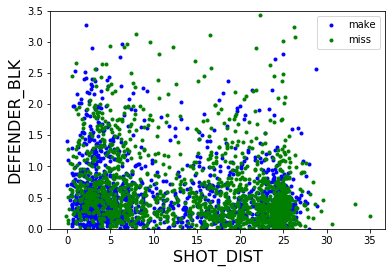

In [17]:
xnames1 = ['SHOT_DIST', 'DEFENDER_BLK']
X1 = Xtrain[xnames1].values

plot_cnt(X1,y,xnames1,ylim=(0,3.5),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

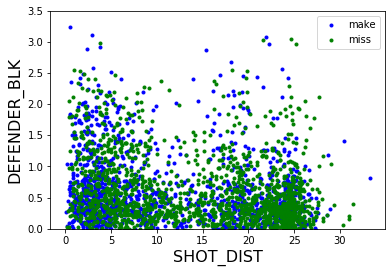

In [18]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

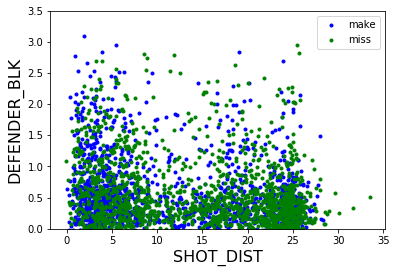

In [19]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=6000,end=9000)

There seems to be a dense region of made shots around higher shot distance and lower BPG of the closest defender and more missed shots closer to the rim. Just to note, defensive stats such as BPG are not always great indicators of a player's defensive ability. 

In [20]:
xnames2 = ['SHOT_DIST', 'CLOSE_DEF_DIST']
X2 = Xtrain[xnames2].values

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

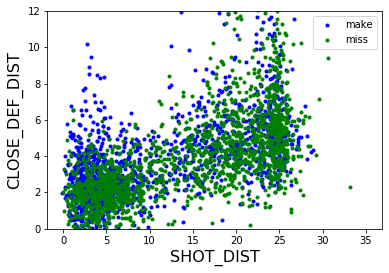

In [21]:
plot_cnt(X2,y,xnames2,ylim=(0,12),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

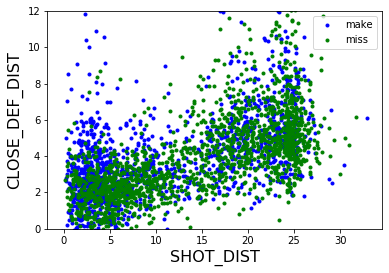

In [22]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

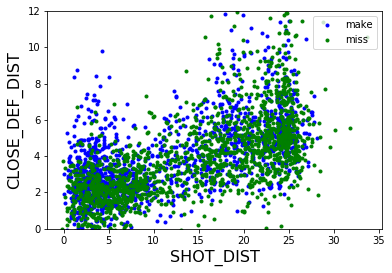

In [23]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

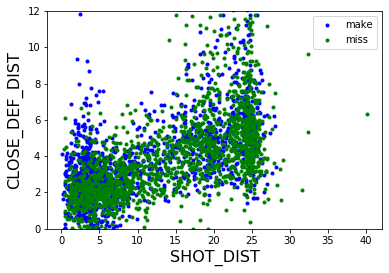

In [24]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=9000,end=12000)

Similar to the relationship between shot distance and distance of the closest defender, there seems to be less missed shots the further away we get from the rim, even if the closest defender is pretty close. It seems that shots at the rim are easier to contest than jump shots, given the nature of how each shot is attempted.

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

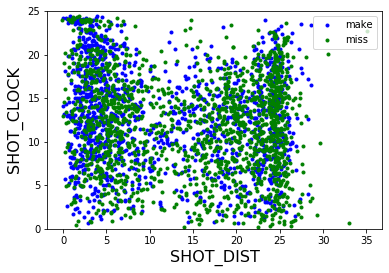

In [25]:
xnames3 = ['SHOT_DIST', 'SHOT_CLOCK']
X3 = Xtrain[xnames3].values

plot_cnt(X3,y,xnames3,ylim=(0,25),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

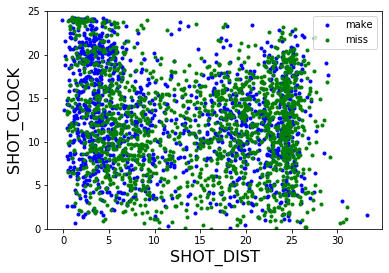

In [26]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

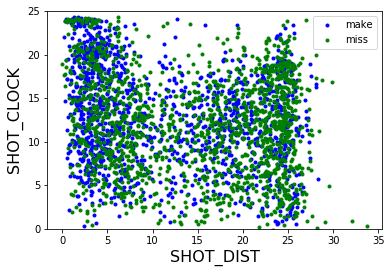

In [27]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

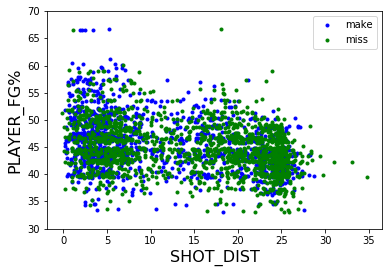

In [28]:
xnames4 = ['SHOT_DIST', 'PLAYER_FG%']
X4 = Xtrain[xnames4].values

plot_cnt(X4,y,labels=xnames4,ylim=(30,70),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

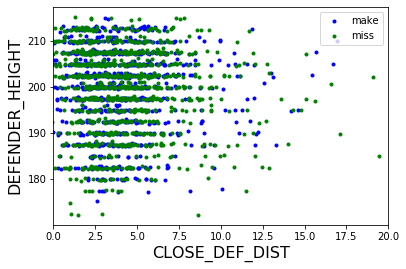

In [29]:
xnames5 = ['CLOSE_DEF_DIST', 'DEFENDER_HEIGHT']
X5 = Xtrain[xnames5].values

plot_cnt(X5,y,xnames5,xlim=(0,20),end=2000)

In [30]:
# feature transformations
Xtrain_new['SHOT_DST/DEF_BLKS'] = \
    Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

Xtest_new['SHOT_DST/DEF_BLKS'] = \
    Xtest_new['SHOT_DIST']/Xtest_new['DEFENDER_BLK']

In [31]:
Xtrain_new[Xtrain_new['SHOT_DST/DEF_BLKS'] == np.inf]

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
52950,11,4,247.0,15.5,1,17.7,2,3.0,187.5,187.5,18.9,44.5,28.5,75.2,1.2,0.0,0,1,inf
98085,1,4,33.0,16.3,3,18.9,2,4.7,195.0,190.0,3.9,40.0,37.5,72.9,0.3,0.0,0,1,inf
2666,2,2,554.0,9.3,2,12.3,2,2.8,202.5,190.0,10.4,43.4,35.8,62.8,0.5,0.0,1,0,inf
22770,3,1,552.0,15.3,3,18.9,2,3.7,195.0,187.5,14.6,39.6,23.5,69.4,0.7,0.0,0,1,inf
52905,2,1,89.0,7.7,3,7.1,2,4.5,182.5,187.5,10.0,42.7,35.1,82.7,1.2,0.0,0,1,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27183,7,1,94.0,20.1,1,6.7,2,18.8,205.0,190.0,21.9,50.2,40.0,72.8,0.4,0.0,0,1,inf
7804,4,2,380.0,15.2,0,25.0,3,4.3,182.5,180.0,12.8,36.8,31.8,75.2,0.6,0.0,1,0,inf
8046,5,4,555.0,15.2,10,21.2,2,2.8,187.5,180.0,7.4,43.8,30.6,67.9,0.6,0.0,0,1,inf
7609,13,4,609.0,18.0,5,24.3,3,8.3,182.5,180.0,10.0,42.7,35.1,82.7,0.4,0.0,0,1,inf


In [32]:
Xtrain_new = Xtrain_new.replace([np.inf, -np.inf],0)
Xtest_new = Xtest_new.replace([np.inf, -np.inf],0)

In [33]:
Xtrain_new

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
93851,9,2,2.0,0.3,27,22.2,2,1.5,195.0,187.5,16.6,44.7,30.4,69.4,0.7,0.3,0,1,74.000000
5515,12,3,168.0,6.3,6,18.5,2,0.5,187.5,190.0,21.7,46.8,41.5,86.3,0.7,0.2,0,1,92.500000
70528,8,4,494.0,17.9,0,1.1,2,2.0,202.5,210.0,10.3,50.2,0.0,71.7,0.5,0.4,1,0,2.750000
79878,1,1,646.0,11.8,1,14.3,2,3.7,212.5,207.5,17.4,49.4,17.6,79.5,0.6,0.9,1,0,15.888889
52950,11,4,247.0,15.5,1,17.7,2,3.0,187.5,187.5,18.9,44.5,28.5,75.2,1.2,0.0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63228,5,2,341.0,12.6,1,15.8,2,5.6,193.0,192.5,21.5,47.0,28.4,76.8,1.9,0.7,1,0,22.571429
9874,3,1,241.0,16.7,7,17.3,2,3.3,192.5,197.5,12.1,43.7,33.1,84.8,0.8,0.2,0,1,86.500000
101158,12,3,264.0,6.1,1,19.9,2,6.4,205.0,202.5,16.4,43.4,36.7,80.4,0.6,0.8,0,1,24.875000
48872,26,4,529.0,22.0,0,27.9,3,4.4,182.5,192.5,14.2,39.7,34.2,87.2,0.8,0.1,1,0,279.000000


In [34]:
scaler_new = StandardScaler()
scaler_new.fit(Xtrain_new)
Xtrain_norm_new = scaler_new.transform(Xtrain_new)
scaler_new.fit(Xtest_new)
Xtest_norm_new = scaler_new.transform(Xtest_new)

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [36]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

Accuracy: 0.601351


Very small increase in accuracy. Let's manually add weights. These weights are a guess on how much a certain feature will play into determining whether a shot is a miss or make. This is just from years of watching and playing basketball. 

In [37]:
# increase weight of player PPG by 5 
Xtrain_norm_new[:,10] = Xtrain_norm_new[:,10] * 5

# increase weight of player FG% by 5
Xtrain_norm_new[:,11] = Xtrain_norm_new[:,11] * 5

# increase weight of player 3P% by 2
Xtrain_norm_new[:,12] = Xtrain_norm_new[:,12] * 2

# increase weight of closest defender distance by 3
Xtrain_norm_new[:,7] = Xtrain_norm_new[:,7] * 3

# increase weight of shot distance by 2
Xtrain_norm_new[:,5] = Xtrain_norm_new[:,5] * 2

In [38]:
# do the same for Xtest
Xtest_norm_new[:,10] = Xtest_norm_new[:,10] * 5
Xtest_norm_new[:,11] = Xtest_norm_new[:,11] * 5
Xtest_norm_new[:,12] = Xtest_norm_new[:,12] * 2
Xtest_norm_new[:,7] = Xtest_norm_new[:,7] * 3
Xtest_norm_new[:,5] = Xtest_norm_new[:,5] * 2

In [39]:
Xtrain_norm_new[0]

array([ 0.54016505, -0.41531748, -1.77558778, -2.12320749,  7.24355646,
        1.96530223, -0.59687287, -2.88713661, -0.2675319 , -1.29391504,
        3.28236443, -0.51617126,  0.02396566, -0.80836072, -0.27819995,
       -0.49304919, -1.00022409,  1.00022409,  0.4384476 ])

In [40]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [41]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

Accuracy: 0.602763


Accuracy went down a bit. It seems that manually setting these weights is difficult, let's try using a neural network to learn these weights/biases/features automatically 

https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation 
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

In [128]:
ytrain = ytrain.values
ytest = ytest.values

In [141]:
# renormalize test and train sets
scaler_new = StandardScaler()
scaler_new.fit(Xtrain)
Xtr_norm = scaler_new.transform(Xtrain)
scaler_new.fit(Xtest)
Xts_norm = scaler_new.transform(Xtest)

In [142]:
K.clear_session()

In [173]:
Xtr_norm.shape

(89258, 19)

In [143]:
nin = Xtr_norm.shape[1] # number of inputs 
nout = 1 # make or miss

In [144]:
# model with two hidden layers with 4 hidden units each
# using sigmoid activation 
model1S = Sequential()
model1S.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model1S.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model1S.add(Dense(units=nout, activation='sigmoid', name='output'))

In [145]:
model1S.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 4)                 80        
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [146]:
opt = optimizers.Adam(lr=0.001)
model1S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [147]:
h1 = model1S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 6s 67us/sample - loss: 0.6949 - accuracy: 0.5443 - val_loss: 0.6786 - val_accuracy: 0.5617
Epoch 2/30
89258/89258 [==============================] - 5s 61us/sample - loss: 0.6753 - accuracy: 0.5912 - val_loss: 0.6706 - val_accuracy: 0.6037
Epoch 3/30
89258/89258 [==============================] - 6s 63us/sample - loss: 0.6684 - accuracy: 0.6038 - val_loss: 0.6648 - val_accuracy: 0.6048
Epoch 4/30
89258/89258 [==============================] - 7s 77us/sample - loss: 0.6639 - accuracy: 0.6063 - val_loss: 0.6614 - val_accuracy: 0.6089
Epoch 5/30
89258/89258 [==============================] - 7s 73us/sample - loss: 0.6613 - accuracy: 0.6093 - val_loss: 0.6596 - val_accuracy: 0.6097
Epoch 6/30
89258/89258 [==============================] - 7s 83us/sample - loss: 0.6596 - accuracy: 0.6111 - val_loss: 0.6581 - val_accuracy: 0.6141
Epoch 7/30
89258/89258 [==============================] 

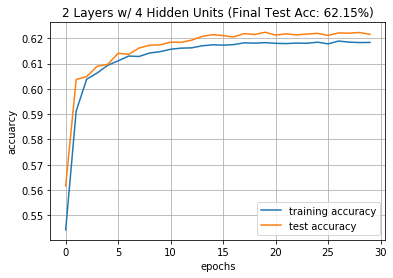

In [153]:
tr_accuracy = h1.history['accuracy']
val_accuracy = h1.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 4 Hidden Units (Final Test Acc: 62.15%)')
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'test accuracy'])

In [149]:
# model with two hidden layers with 8 hidden units each
# using sigmoid activation 
model2S = Sequential()
model2S.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model2S.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model2S.add(Dense(units=nout, activation='sigmoid', name='output'))
model2S.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 8)                 160       
_________________________________________________________________
hidden2 (Dense)              (None, 8)                 72        
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [150]:
model2S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [151]:
h2 = model2S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6674 - accuracy: 0.5976 - val_loss: 0.6602 - val_accuracy: 0.6076
Epoch 2/30
89258/89258 [==============================] - 7s 76us/sample - loss: 0.6600 - accuracy: 0.6086 - val_loss: 0.6580 - val_accuracy: 0.6149
Epoch 3/30
89258/89258 [==============================] - 7s 79us/sample - loss: 0.6582 - accuracy: 0.6111 - val_loss: 0.6565 - val_accuracy: 0.6168
Epoch 4/30
89258/89258 [==============================] - 7s 74us/sample - loss: 0.6569 - accuracy: 0.6126 - val_loss: 0.6551 - val_accuracy: 0.6142
Epoch 5/30
89258/89258 [==============================] - 6s 70us/sample - loss: 0.6558 - accuracy: 0.6132 - val_loss: 0.6548 - val_accuracy: 0.6113
Epoch 6/30
89258/89258 [==============================] - 7s 76us/sample - loss: 0.6549 - accuracy: 0.6145 - val_loss: 0.6534 - val_accuracy: 0.6176
Epoch 7/30
89258/89258 [==============================] 

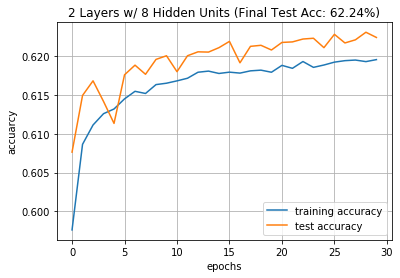

In [155]:
tr_accuracy = h2.history['accuracy']
val_accuracy = h2.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 8 Hidden Units (Final Test Acc: 62.24%)')
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'test accuracy'])

In [156]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model3S = Sequential()
model3S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model3S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model3S.add(Dense(units=nout, activation='sigmoid', name='output'))
model3S.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                240       
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________


In [157]:
model3S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [158]:
h3 = model3S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 8s 84us/sample - loss: 0.6662 - accuracy: 0.6023 - val_loss: 0.6577 - val_accuracy: 0.6099
Epoch 2/30
89258/89258 [==============================] - 7s 76us/sample - loss: 0.6574 - accuracy: 0.6116 - val_loss: 0.6552 - val_accuracy: 0.6117
Epoch 3/30
89258/89258 [==============================] - 7s 76us/sample - loss: 0.6556 - accuracy: 0.6134 - val_loss: 0.6537 - val_accuracy: 0.6156
Epoch 4/30
89258/89258 [==============================] - 7s 81us/sample - loss: 0.6545 - accuracy: 0.6134 - val_loss: 0.6527 - val_accuracy: 0.6196
Epoch 5/30
89258/89258 [==============================] - 8s 92us/sample - loss: 0.6535 - accuracy: 0.6151 - val_loss: 0.6520 - val_accuracy: 0.6175
Epoch 6/30
89258/89258 [==============================] - 8s 93us/sample - loss: 0.6528 - accuracy: 0.6163 - val_loss: 0.6510 - val_accuracy: 0.6207
Epoch 7/30
89258/89258 [==============================] 

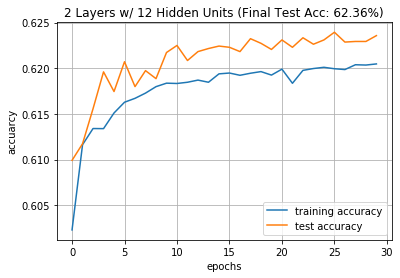

In [159]:
tr_accuracy = h3.history['accuracy']
val_accuracy = h3.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 12 Hidden Units (Final Test Acc: 62.36%)')
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'test accuracy'])

In [160]:
# model with two hidden layers with 16 hidden units each
# using sigmoid activation 
model4S = Sequential()
model4S.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model4S.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model4S.add(Dense(units=nout, activation='sigmoid', name='output'))
model4S.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                320       
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [161]:
model4S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [162]:
h4 = model4S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 10s 114us/sample - loss: 0.6634 - accuracy: 0.6039 - val_loss: 0.6580 - val_accuracy: 0.6103
Epoch 2/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6584 - accuracy: 0.6093 - val_loss: 0.6569 - val_accuracy: 0.6154
Epoch 3/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6570 - accuracy: 0.6110 - val_loss: 0.6551 - val_accuracy: 0.6145
Epoch 4/30
89258/89258 [==============================] - 8s 87us/sample - loss: 0.6555 - accuracy: 0.6130 - val_loss: 0.6537 - val_accuracy: 0.6192
Epoch 5/30
89258/89258 [==============================] - 7s 84us/sample - loss: 0.6542 - accuracy: 0.6148 - val_loss: 0.6527 - val_accuracy: 0.6204
Epoch 6/30
89258/89258 [==============================] - 8s 90us/sample - loss: 0.6532 - accuracy: 0.6144 - val_loss: 0.6517 - val_accuracy: 0.6202
Epoch 7/30
89258/89258 [==============================

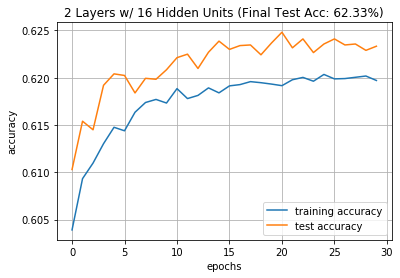

In [179]:
tr_accuracy = h4.history['accuracy']
val_accuracy = h4.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 16 Hidden Units (Final Test Acc: 62.33%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'])

In [174]:
# model with two hidden layers with 20 hidden units each
# using sigmoid activation 
model5S = Sequential()
model5S.add(Dense(units=19, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model5S.add(Dense(units=19, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model5S.add(Dense(units=nout, activation='sigmoid', name='output'))
model5S.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 19)                380       
_________________________________________________________________
hidden2 (Dense)              (None, 19)                380       
_________________________________________________________________
output (Dense)               (None, 1)                 20        
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________


In [175]:
model5S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [176]:
h5 = model5S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 11s 119us/sample - loss: 0.6634 - accuracy: 0.6021 - val_loss: 0.6584 - val_accuracy: 0.6060
Epoch 2/30
89258/89258 [==============================] - 9s 105us/sample - loss: 0.6583 - accuracy: 0.6093 - val_loss: 0.6565 - val_accuracy: 0.6118
Epoch 3/30
89258/89258 [==============================] - 9s 102us/sample - loss: 0.6573 - accuracy: 0.6104 - val_loss: 0.6557 - val_accuracy: 0.6171
Epoch 4/30
89258/89258 [==============================] - 9s 104us/sample - loss: 0.6561 - accuracy: 0.6118 - val_loss: 0.6549 - val_accuracy: 0.6167
Epoch 5/30
89258/89258 [==============================] - 9s 104us/sample - loss: 0.6552 - accuracy: 0.6127 - val_loss: 0.6550 - val_accuracy: 0.6204
Epoch 6/30
89258/89258 [==============================] - 10s 116us/sample - loss: 0.6543 - accuracy: 0.6142 - val_loss: 0.6529 - val_accuracy: 0.6168
Epoch 7/30
89258/89258 [========================

Accuracy doesn't seem to go over 62% with any of the models trained.
We did not include the identity of either the player or the closest defender. Would that play a role in increasing accuracy?


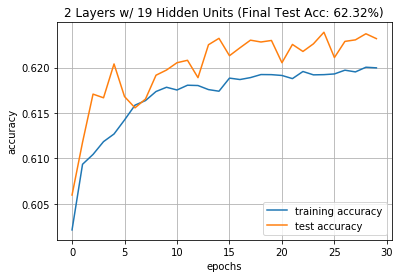

In [183]:
tr_accuracy = h5.history['accuracy']
val_accuracy = h5.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 19 Hidden Units (Final Test Acc: 62.32%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [196]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model6S = Sequential()
model6S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model6S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model6S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden3'))
model6S.add(Dense(units=nout, activation='sigmoid', name='output'))
model6S.summary()

model6S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                240       
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
hidden3 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 565
Trainable params: 565
Non-trainable params: 0
_________________________________________________________________


In [197]:
h6 = model6S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 5s 50us/sample - loss: 0.6743 - accuracy: 0.5921 - val_loss: 0.6593 - val_accuracy: 0.6140
Epoch 2/30
89258/89258 [==============================] - 5s 53us/sample - loss: 0.6576 - accuracy: 0.6132 - val_loss: 0.6546 - val_accuracy: 0.6164
Epoch 3/30
89258/89258 [==============================] - 5s 58us/sample - loss: 0.6543 - accuracy: 0.6160 - val_loss: 0.6518 - val_accuracy: 0.6202
Epoch 4/30
89258/89258 [==============================] - 5s 53us/sample - loss: 0.6529 - accuracy: 0.6172 - val_loss: 0.6508 - val_accuracy: 0.6213
Epoch 5/30
89258/89258 [==============================] - 4s 48us/sample - loss: 0.6522 - accuracy: 0.6177 - val_loss: 0.6502 - val_accuracy: 0.6211
Epoch 6/30
89258/89258 [==============================] - 5s 50us/sample - loss: 0.6518 - accuracy: 0.6178 - val_loss: 0.6501 - val_accuracy: 0.6211
Epoch 7/30
89258/89258 [==============================] 

In [235]:
namesv2 = ['GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'PTS_TYPE',
           'PLAYER_PTS', 'DEFENDER_STL', 'SHOT_RESULT']

d = pd.get_dummies(data[namesv2])

# split into train and test set with roughly 75-25 split
tr, ts = train_test_split(d, test_size=0.25)
Xtrn = tr.drop(['SHOT_RESULT'], axis=1)
ytrn = tr['SHOT_RESULT']
Xtsn = ts.drop(['SHOT_RESULT'], axis=1)
ytsn = ts['SHOT_RESULT']

In [236]:
# normalize
scaler = StandardScaler()
scaler.fit(Xtrn)
Xtrn = scaler.transform(Xtrn)
scaler.fit(Xtsn)
Xtsn = scaler.transform(Xtsn)

In [238]:
ytrn = ytrn.values
ytsn = ytsn.values

In [237]:
nin = Xtrn.shape[1]

In [239]:
K.clear_session()

In [240]:
# model with two hidden layers with 4 hidden units each
# using sigmoid activation 
mn = Sequential()
mn.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden1'))
mn.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden2'))
mn.add(Dense(units=nout, activation='sigmoid', name='output'))
mn.summary()

mn.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 4)                 32        
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [241]:
hist = mn.fit(Xtrn, ytrn, epochs=30, batch_size=100, validation_data=(Xtsn,ytsn))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 4s 44us/sample - loss: 0.6822 - accuracy: 0.5660 - val_loss: 0.6761 - val_accuracy: 0.5780
Epoch 2/30
89258/89258 [==============================] - 4s 44us/sample - loss: 0.6762 - accuracy: 0.5777 - val_loss: 0.6749 - val_accuracy: 0.5793
Epoch 3/30
89258/89258 [==============================] - 4s 48us/sample - loss: 0.6756 - accuracy: 0.5770 - val_loss: 0.6746 - val_accuracy: 0.5805
Epoch 4/30
89258/89258 [==============================] - 4s 47us/sample - loss: 0.6753 - accuracy: 0.5778 - val_loss: 0.6745 - val_accuracy: 0.5801
Epoch 5/30
89258/89258 [==============================] - 4s 43us/sample - loss: 0.6751 - accuracy: 0.5782 - val_loss: 0.6743 - val_accuracy: 0.5794
Epoch 6/30
89258/89258 [==============================] - 4s 47us/sample - loss: 0.6749 - accuracy: 0.5788 - val_loss: 0.6743 - val_accuracy: 0.5806
Epoch 7/30
89258/89258 [==============================] 

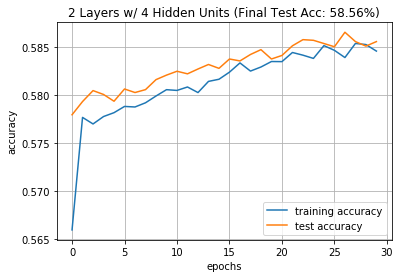

In [257]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 4 Hidden Units (Final Test Acc: 58.56%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [244]:
# model with two hidden layers with 5 hidden units each
# using sigmoid activation 
mn1 = Sequential()
mn1.add(Dense(units=5, input_shape=(nin,), activation='sigmoid', name='hidden1'))
mn1.add(Dense(units=5, input_shape=(nin,), activation='sigmoid', name='hidden2'))
mn1.add(Dense(units=nout, activation='sigmoid', name='output'))
mn1.summary()

mn1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 5)                 40        
_________________________________________________________________
hidden2 (Dense)              (None, 5)                 30        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [245]:
hist1 = mn1.fit(Xtrn, ytrn, epochs=30, batch_size=100, validation_data=(Xtsn,ytsn))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 4s 49us/sample - loss: 0.6780 - accuracy: 0.5730 - val_loss: 0.6750 - val_accuracy: 0.5796
Epoch 2/30
89258/89258 [==============================] - 5s 55us/sample - loss: 0.6757 - accuracy: 0.5761 - val_loss: 0.6748 - val_accuracy: 0.5793
Epoch 3/30
89258/89258 [==============================] - 4s 46us/sample - loss: 0.6753 - accuracy: 0.5768 - val_loss: 0.6744 - val_accuracy: 0.5806
Epoch 4/30
89258/89258 [==============================] - 4s 41us/sample - loss: 0.6750 - accuracy: 0.5783 - val_loss: 0.6740 - val_accuracy: 0.5797
Epoch 5/30
89258/89258 [==============================] - 3s 39us/sample - loss: 0.6747 - accuracy: 0.5784 - val_loss: 0.6739 - val_accuracy: 0.5807
Epoch 6/30
89258/89258 [==============================] - 4s 44us/sample - loss: 0.6745 - accuracy: 0.5791 - val_loss: 0.6738 - val_accuracy: 0.5813
Epoch 7/30
89258/89258 [==============================] 

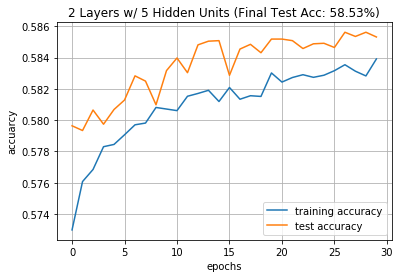

In [249]:
tr_accuracy = hist1.history['accuracy']
val_accuracy = hist1.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 5 Hidden Units (Final Test Acc: 58.53%)')
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'test accuracy'])

In [247]:
# model with two hidden layers with 6 hidden units each
# using sigmoid activation 
mn2 = Sequential()
mn2.add(Dense(units=6, input_shape=(nin,), activation='sigmoid', name='hidden1'))
mn2.add(Dense(units=6, input_shape=(nin,), activation='sigmoid', name='hidden2'))
mn2.add(Dense(units=nout, activation='sigmoid', name='output'))
mn2.summary()

mn2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 6)                 48        
_________________________________________________________________
hidden2 (Dense)              (None, 6)                 42        
_________________________________________________________________
output (Dense)               (None, 1)                 7         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [248]:
hist2 = mn2.fit(Xtrn, ytrn, epochs=30, batch_size=100, validation_data=(Xtsn,ytsn))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 4s 46us/sample - loss: 0.6807 - accuracy: 0.5670 - val_loss: 0.6762 - val_accuracy: 0.5762
Epoch 2/30
89258/89258 [==============================] - 5s 54us/sample - loss: 0.6769 - accuracy: 0.5744 - val_loss: 0.6755 - val_accuracy: 0.5790
Epoch 3/30
89258/89258 [==============================] - 4s 48us/sample - loss: 0.6763 - accuracy: 0.5753 - val_loss: 0.6752 - val_accuracy: 0.5780
Epoch 4/30
89258/89258 [==============================] - 4s 50us/sample - loss: 0.6759 - accuracy: 0.5755 - val_loss: 0.6751 - val_accuracy: 0.5776
Epoch 5/30
89258/89258 [==============================] - 5s 57us/sample - loss: 0.6756 - accuracy: 0.5766 - val_loss: 0.6745 - val_accuracy: 0.5796
Epoch 6/30
89258/89258 [==============================] - 4s 46us/sample - loss: 0.6753 - accuracy: 0.5779 - val_loss: 0.6743 - val_accuracy: 0.5811
Epoch 7/30
89258/89258 [==============================] 

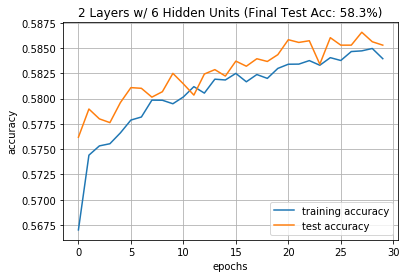

In [256]:
tr_accuracy = hist2.history['accuracy']
val_accuracy = hist2.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 6 Hidden Units (Final Test Acc: 58.3%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [251]:
# model with two hidden layers with 4 hidden units each
# using sigmoid activation 
mn3 = Sequential()
mn3.add(Dense(units=7, input_shape=(nin,), activation='sigmoid', name='hidden1'))
mn3.add(Dense(units=7, input_shape=(nin,), activation='sigmoid', name='hidden2'))
mn3.add(Dense(units=nout, activation='sigmoid', name='output'))
mn3.summary()

mn3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 7)                 56        
_________________________________________________________________
hidden2 (Dense)              (None, 7)                 56        
_________________________________________________________________
output (Dense)               (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [252]:
hist3 = mn3.fit(Xtrn, ytrn, epochs=30, batch_size=100, validation_data=(Xtsn,ytsn))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 4s 47us/sample - loss: 0.6777 - accuracy: 0.5733 - val_loss: 0.6749 - val_accuracy: 0.5796
Epoch 2/30
89258/89258 [==============================] - 4s 42us/sample - loss: 0.6756 - accuracy: 0.5764 - val_loss: 0.6746 - val_accuracy: 0.5803
Epoch 3/30
89258/89258 [==============================] - 5s 53us/sample - loss: 0.6752 - accuracy: 0.5771 - val_loss: 0.6743 - val_accuracy: 0.5811
Epoch 4/30
89258/89258 [==============================] - 4s 48us/sample - loss: 0.6749 - accuracy: 0.5786 - val_loss: 0.6741 - val_accuracy: 0.5807
Epoch 5/30
89258/89258 [==============================] - 4s 44us/sample - loss: 0.6747 - accuracy: 0.5780 - val_loss: 0.6739 - val_accuracy: 0.5814
Epoch 6/30
89258/89258 [==============================] - 4s 43us/sample - loss: 0.6745 - accuracy: 0.5798 - val_loss: 0.6740 - val_accuracy: 0.5815
Epoch 7/30
89258/89258 [==============================] 

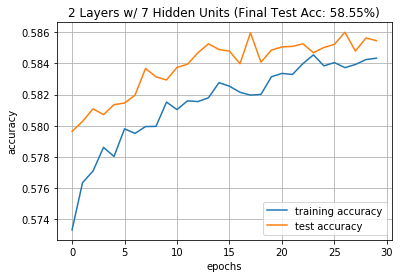

In [255]:
tr_accuracy = hist3.history['accuracy']
val_accuracy = hist3.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 7 Hidden Units (Final Test Acc: 58.55%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [264]:
namesv3 = ['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'PTS_TYPE', 'PLAYER_HEIGHT', 'PLAYER_PTS',
       'PLAYER_FG%', 'PLAYER_3P%', 'PLAYER_FT%', 'DEFENDER_STL', 'SHOT_RESULT']

d = pd.get_dummies(data[namesv3])

# split into train and test set with roughly 75-25 split
tr, ts = train_test_split(d, test_size=0.25)
Xtrn1 = tr.drop(['SHOT_RESULT'], axis=1)
ytrn1 = tr['SHOT_RESULT']
Xtsn1 = ts.drop(['SHOT_RESULT'], axis=1)
ytsn1 = ts['SHOT_RESULT']
ytrn1 = ytrn1.values
ytsn1 = ytsn1.values

In [265]:
# normalize
scaler = StandardScaler()
scaler.fit(Xtrn1)
Xtrn1 = scaler.transform(Xtrn1)
scaler.fit(Xtsn1)
Xtsn1 = scaler.transform(Xtsn1)

nin = Xtrn1.shape[1]

In [266]:
K.clear_session()

In [267]:
# model with two hidden layers with 4 hidden units each
# using sigmoid activation 
model = Sequential()
model.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))
model.summary()

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 4)                 56        
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [269]:
h1 = model.fit(Xtrn1, ytrn1, epochs=30, batch_size=100, validation_data=(Xtsn1,ytsn1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 5s 58us/sample - loss: 0.6786 - accuracy: 0.5728 - val_loss: 0.6743 - val_accuracy: 0.5834
Epoch 2/30
89258/89258 [==============================] - 5s 51us/sample - loss: 0.6745 - accuracy: 0.5822 - val_loss: 0.6735 - val_accuracy: 0.5846
Epoch 3/30
89258/89258 [==============================] - 5s 57us/sample - loss: 0.6740 - accuracy: 0.5832 - val_loss: 0.6730 - val_accuracy: 0.5865
Epoch 4/30
89258/89258 [==============================] - 5s 57us/sample - loss: 0.6737 - accuracy: 0.5835 - val_loss: 0.6727 - val_accuracy: 0.5870
Epoch 5/30
89258/89258 [==============================] - 4s 42us/sample - loss: 0.6734 - accuracy: 0.5839 - val_loss: 0.6724 - val_accuracy: 0.5868
Epoch 6/30
89258/89258 [==============================] - 4s 50us/sample - loss: 0.6732 - accuracy: 0.5850 - val_loss: 0.6722 - val_accuracy: 0.5876
Epoch 7/30
89258/89258 [==============================] 

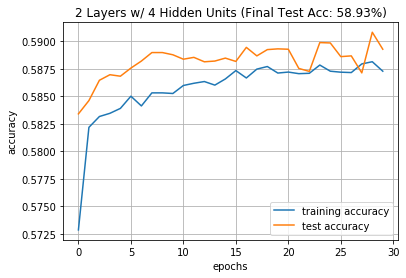

In [270]:
tr_accuracy = h1.history['accuracy']
val_accuracy = h1.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 4 Hidden Units (Final Test Acc: 58.93%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [271]:
# model with two hidden layers with 8 hidden units each
# using sigmoid activation 
model2 = Sequential()
model2.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model2.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model2.add(Dense(units=nout, activation='sigmoid', name='output'))
model2.summary()

model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 8)                 112       
_________________________________________________________________
hidden2 (Dense)              (None, 8)                 72        
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [272]:
h2 = model2.fit(Xtrn1, ytrn1, epochs=30, batch_size=100, validation_data=(Xtsn1,ytsn1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 4s 50us/sample - loss: 0.6772 - accuracy: 0.5761 - val_loss: 0.6741 - val_accuracy: 0.5833
Epoch 2/30
89258/89258 [==============================] - 4s 41us/sample - loss: 0.6745 - accuracy: 0.5817 - val_loss: 0.6739 - val_accuracy: 0.5834
Epoch 3/30
89258/89258 [==============================] - 4s 47us/sample - loss: 0.6741 - accuracy: 0.5822 - val_loss: 0.6732 - val_accuracy: 0.5860
Epoch 4/30
89258/89258 [==============================] - 4s 46us/sample - loss: 0.6738 - accuracy: 0.5826 - val_loss: 0.6728 - val_accuracy: 0.5853
Epoch 5/30
89258/89258 [==============================] - 5s 57us/sample - loss: 0.6736 - accuracy: 0.5826 - val_loss: 0.6726 - val_accuracy: 0.5861
Epoch 6/30
89258/89258 [==============================] - 5s 57us/sample - loss: 0.6733 - accuracy: 0.5844 - val_loss: 0.6724 - val_accuracy: 0.5868
Epoch 7/30
89258/89258 [==============================] 

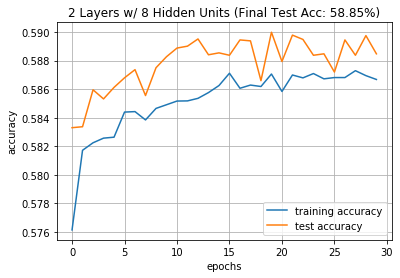

In [278]:
tr_accuracy = h2.history['accuracy']
val_accuracy = h2.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 8 Hidden Units (Final Test Acc: 58.85%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [274]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model3 = Sequential()
model3.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model3.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model3.add(Dense(units=nout, activation='sigmoid', name='output'))
model3.summary()

model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                168       
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [275]:
h3 = model3.fit(Xtrn1, ytrn1, epochs=30, batch_size=100, validation_data=(Xtsn1,ytsn1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 5s 54us/sample - loss: 0.6772 - accuracy: 0.5770 - val_loss: 0.6731 - val_accuracy: 0.5861
Epoch 2/30
89258/89258 [==============================] - 5s 59us/sample - loss: 0.6737 - accuracy: 0.5828 - val_loss: 0.6725 - val_accuracy: 0.5857
Epoch 3/30
89258/89258 [==============================] - 8s 84us/sample - loss: 0.6733 - accuracy: 0.5836 - val_loss: 0.6721 - val_accuracy: 0.5865
Epoch 4/30
89258/89258 [==============================] - 7s 76us/sample - loss: 0.6731 - accuracy: 0.5846 - val_loss: 0.6719 - val_accuracy: 0.5878
Epoch 5/30
89258/89258 [==============================] - 5s 60us/sample - loss: 0.6728 - accuracy: 0.5842 - val_loss: 0.6717 - val_accuracy: 0.5874
Epoch 6/30
89258/89258 [==============================] - 5s 58us/sample - loss: 0.6727 - accuracy: 0.5846 - val_loss: 0.6717 - val_accuracy: 0.5882
Epoch 7/30
89258/89258 [==============================] 

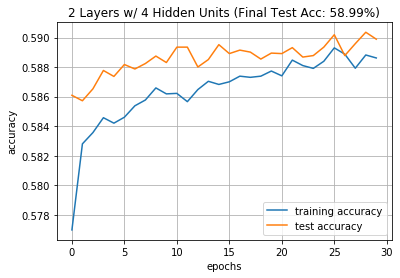

In [277]:
tr_accuracy = h3.history['accuracy']
val_accuracy = h3.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.title('2 Layers w/ 4 Hidden Units (Final Test Acc: 58.99%)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'test accuracy'], loc='lower right')

In [188]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [184]:
def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(12, input_shape=(nin,), 
                    kernel_initializer=init_mode, 
                    activation='sigmoid')) 
    model.add(Dense(12, input_shape=(nin,), 
                    kernel_initializer=init_mode, 
                    activation='sigmoid'))
    model.add(Dense(units=nout, 
                    kernel_initializer=init_mode, 
                    activation='sigmoid', 
                    name='output'))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model


In [191]:
model_CV = KerasClassifier(build_fn=create_model, verbose=1)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
batches = [100, 300, 500]
epochs = [30, 40, 50]

param_grid = dict(epochs=epochs, batch_size=batches, init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xtr_norm, ytrain)

Train on 89258 samples
Epoch 1/30
89258/89258 [==============================] - 6s 63us/sample - loss: 0.6666 - accuracy: 0.6006
Epoch 2/30
89258/89258 [==============================] - 6s 69us/sample - loss: 0.6568 - accuracy: 0.6131
Epoch 3/30
89258/89258 [==============================] - 6s 66us/sample - loss: 0.6549 - accuracy: 0.6145
Epoch 4/30
89258/89258 [==============================] - 5s 59us/sample - loss: 0.6537 - accuracy: 0.6150
Epoch 5/30
89258/89258 [==============================] - 5s 59us/sample - loss: 0.6528 - accuracy: 0.6161
Epoch 6/30
89258/89258 [==============================] - 5s 58us/sample - loss: 0.6521 - accuracy: 0.6167
Epoch 7/30
89258/89258 [==============================] - 6s 63us/sample - loss: 0.6516 - accuracy: 0.6169
Epoch 8/30
89258/89258 [==============================] - 6s 72us/sample - loss: 0.6513 - accuracy: 0.6177
Epoch 9/30
89258/89258 [==============================] - 6s 72us/sample - loss: 0.6509 - accuracy: 0.6175
Epoch 10/30
89

In [192]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.6195187025038779 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'glorot_uniform'}
 mean=0.6186, std=0.0009356 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'uniform'}
 mean=0.6185, std=0.001604 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'lecun_uniform'}
 mean=0.6187, std=0.0005808 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'normal'}
 mean=0.6188, std=0.001176 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'zero'}
 mean=0.6188, std=0.0009143 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'glorot_normal'}
 mean=0.6195, std=0.001265 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'glorot_uniform'}
 mean=0.6186, std=0.0005005 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'he_normal'}
 mean=0.6193, std=0.0008567 using {'batch_size': 100, 'epochs': 30, 'init_mode': 'he_uniform'}
 mean=0.6192, std=7.399e-05 using {'batch_size': 100, 'epochs': 40, 'init_mode': 'uniform'}
 mean=0.6184, std=0.00194 using {'batch_size': 

In [70]:
data1 = pd.read_csv('Data/data.csv')

# separate data into matrix of predictor variables and vector of target variables
names1 = ['LOCATION', 'PLAYER_NAME', 'CLOSEST_DEFENDER','SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
         'DRIBBLES', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 
         'PLAYER_HEIGHT','DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
          'PLAYER_FT%','DEFENDER_STL', 'DEFENDER_BLK', 'SHOT_RESULT']

# convert shot_result to either 0 or 1
data1['SHOT_RESULT'] = (data1['SHOT_RESULT'] == 'made').astype(int)

# convert game_clock to seconds
data1['GAME_CLOCK'] = data1['GAME_CLOCK'].apply(lambda x: convert_time(x))

# encode categorical data 
data_encoded = pd.get_dummies(data1[names1])

# split into train and test set with roughly 75-25 split
train, test = train_test_split(data_encoded, test_size=0.25)
Xtr1 = train.drop(['SHOT_RESULT'], axis=1)
ytr1 = train['SHOT_RESULT']
Xts1 = test.drop(['SHOT_RESULT'], axis=1)
yts1 = test['SHOT_RESULT']

In [71]:
ytr1 = ytr1.values
yts1 = yts1.values

In [86]:
# normalization
scaler = StandardScaler()
scaler.fit(Xtr1)
Xtr1 = scaler.transform(Xtr1)
scaler.fit(Xts1)
Xts1 = scaler.transform(Xts1)

In [87]:
K.clear_session()

In [88]:
Xtr1.shape

(89258, 769)

In [89]:
nin = Xtr1.shape[1] # number of inputs 
nout = 1 # make or miss

In [90]:
# model with two hidden layers with 100 hidden units each
# using sigmoid activation 
model100 = Sequential()
model100.add(Dense(units=100, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model100.add(Dense(units=100, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model100.add(Dense(units=nout, activation='sigmoid', name='output'))
model100.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               77000     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [91]:
model100.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
model100.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 11s 128us/sample - loss: 0.6763 - accuracy: 0.5783 - val_loss: 0.6663 - val_accuracy: 0.5968
Epoch 2/30
89258/89258 [==============================] - 10s 111us/sample - loss: 0.6591 - accuracy: 0.6081 - val_loss: 0.6614 - val_accuracy: 0.6040
Epoch 3/30
89258/89258 [==============================] - 10s 112us/sample - loss: 0.6509 - accuracy: 0.6173 - val_loss: 0.6599 - val_accuracy: 0.6113
Epoch 4/30
89258/89258 [==============================] - 10s 110us/sample - loss: 0.6426 - accuracy: 0.6251 - val_loss: 0.6594 - val_accuracy: 0.6139
Epoch 5/30
89258/89258 [==============================] - 10s 109us/sample - loss: 0.6339 - accuracy: 0.6346 - val_loss: 0.6635 - val_accuracy: 0.6108
Epoch 6/30
89258/89258 [==============================] - 10s 114us/sample - loss: 0.6222 - accuracy: 0.6437 - val_loss: 0.6681 - val_accuracy: 0.6017
Epoch 7/30
89258/89258 [====================

Validation accuracy horrible while training accuracy goes up. Overfitting? Decrease hidden units. Let's start low again. From 16 let's say. And go up to ~50

In [93]:
# model with two hidden layers with 16 hidden units each
# using sigmoid activation 
model16 = Sequential()
model16.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model16.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model16.add(Dense(units=nout, activation='sigmoid', name='output'))
model16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                12320     
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________


In [94]:
model16.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
model16.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 84us/sample - loss: 0.6766 - accuracy: 0.5793 - val_loss: 0.6666 - val_accuracy: 0.5992
Epoch 2/30
89258/89258 [==============================] - 7s 78us/sample - loss: 0.6603 - accuracy: 0.6082 - val_loss: 0.6634 - val_accuracy: 0.6040
Epoch 3/30
89258/89258 [==============================] - 8s 88us/sample - loss: 0.6540 - accuracy: 0.6163 - val_loss: 0.6611 - val_accuracy: 0.6086
Epoch 4/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6491 - accuracy: 0.6214 - val_loss: 0.6601 - val_accuracy: 0.6099
Epoch 5/30
89258/89258 [==============================] - 9s 98us/sample - loss: 0.6445 - accuracy: 0.6269 - val_loss: 0.6604 - val_accuracy: 0.6097
Epoch 6/30
89258/89258 [==============================] - 9s 103us/sample - loss: 0.6402 - accuracy: 0.6316 - val_loss: 0.6610 - val_accuracy: 0.6082
Epoch 7/30
89258/89258 [==============================]

In [99]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model12 = Sequential()
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model12.add(Dense(units=nout, activation='sigmoid', name='output'))
model12.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                9240      
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [101]:
model12.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [103]:
model20.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 8s 88us/sample - loss: 0.6748 - accuracy: 0.5809 - val_loss: 0.6672 - val_accuracy: 0.5983
Epoch 2/30
89258/89258 [==============================] - 8s 89us/sample - loss: 0.6612 - accuracy: 0.6062 - val_loss: 0.6639 - val_accuracy: 0.6027
Epoch 3/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6549 - accuracy: 0.6149 - val_loss: 0.6619 - val_accuracy: 0.6052
Epoch 4/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6500 - accuracy: 0.6201 - val_loss: 0.6596 - val_accuracy: 0.6100
Epoch 5/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6451 - accuracy: 0.6259 - val_loss: 0.6589 - val_accuracy: 0.6101
Epoch 6/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6404 - accuracy: 0.6307 - val_loss: 0.6600 - val_accuracy: 0.6103
Epoch 7/30
89258/89258 [==============================

In [ ]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model12 = Sequential()
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model12.add(Dense(units=nout, activation='sigmoid', name='output'))
model12.summary()

In [104]:
model12.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [105]:
model12.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6764 - accuracy: 0.5782 - val_loss: 0.6675 - val_accuracy: 0.5987
Epoch 2/30
89258/89258 [==============================] - 7s 77us/sample - loss: 0.6616 - accuracy: 0.6066 - val_loss: 0.6647 - val_accuracy: 0.6036
Epoch 3/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6557 - accuracy: 0.6143 - val_loss: 0.6629 - val_accuracy: 0.6057
Epoch 4/30
89258/89258 [==============================] - 8s 85us/sample - loss: 0.6513 - accuracy: 0.6189 - val_loss: 0.6616 - val_accuracy: 0.6077
Epoch 5/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6472 - accuracy: 0.6241 - val_loss: 0.6616 - val_accuracy: 0.6067
Epoch 6/30
89258/89258 [==============================] - 8s 94us/sample - loss: 0.6433 - accuracy: 0.6283 - val_loss: 0.6611 - val_accuracy: 0.6060
Epoch 7/30
89258/89258 [==============================]

reweight parameters 
try different number of neighbors
feature transformation 
- ratio of shot distance to shot defender, etc
- do we keep the original features 
try logistic regression 
 

In [ ]:
Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

In [ ]:
plt.ylim(6)